## Imports

In [116]:
import pandas as pd
from matplotlib import pyplot as plt
from bokeh.models import HoverTool, ColumnDataSource, CustomJS, Legend
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.layouts import gridplot, column, Row
output_notebook()

Loading BokehJS ...

In [24]:
df = pd.read_csv('C:/Users/Paula/Documents/DTU/Spring_2024/Social_data/project/FinalProject---SocialData24.github.io/Air_Traffic_Passenger_Statistics_20240408.csv')

### Basic Stat

#### Data preprocessing and cleaning

In [25]:
# Delete duplicates
df = df.drop_duplicates()

In [26]:
# Find rows with one or more empty columns
empty_rows = df[df.isnull().any(axis=1)]

# Find columns with empty values
empty_columns = []
for index, row in empty_rows.iterrows():
    empty_columns.extend([col for col in df.columns if pd.isnull(row[col])])

unique_empty_columns = list(set(empty_columns))
print(unique_empty_columns)


['Published Airline IATA Code', 'Operating Airline IATA Code']


Since the only columns that have empty values are these two, we decided to remove them because the information in them is the same as the one in "Operating Airline" and "Published Airline" columns.

In [27]:
df.drop(columns=['Published Airline IATA Code', 'Operating Airline IATA Code'], inplace=True)

In [28]:
# Convert columns to datetime format
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])
df.drop(columns=['Activity Period'], inplace=True)

In [29]:
# Clean unnecessary columns
df.drop(columns=['data_as_of', 'data_loaded_at'], inplace=True)

In [30]:
df = df[(df['Activity Period Start Date'].dt.year != 1999) & (df['Activity Period Start Date'].dt.year != 2024)]

In [31]:
df.head()

,Activity Period Start Date,Operating Airline,Published Airline,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
760,2000-01-01,ATA Airlines,ATA Airlines,Domestic,US,Deplaned,Low Fare,Terminal 1,B,17578
761,2000-01-01,ATA Airlines,ATA Airlines,Domestic,US,Enplaned,Low Fare,Terminal 1,B,16606
762,2000-01-01,ATA Airlines,ATA Airlines,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,2616
763,2000-01-01,ATA Airlines,ATA Airlines,International,Canada,Deplaned,Low Fare,Terminal 1,B,95
764,2000-01-01,Aeroflot Russian International Airlines,Aeroflot Russian International Airlines,International,Europe,Deplaned,Other,Terminal 2,D,811


In [32]:
df.describe()

,Activity Period Start Date,Passenger Count
count,34575,34575.000000
mean,2012-06-16 19:08:47.583513856,27997.878872
min,2000-01-01 00:00:00,0.000000
25%,2006-08-01 00:00:00,4465.000000
50%,2012-10-01 00:00:00,8657.000000
75%,2018-06-01 00:00:00,19897.500000
max,2023-12-01 00:00:00,728304.000000
std,NaN,61931.441368


Total amount of passengers without taking into account what they are doing there

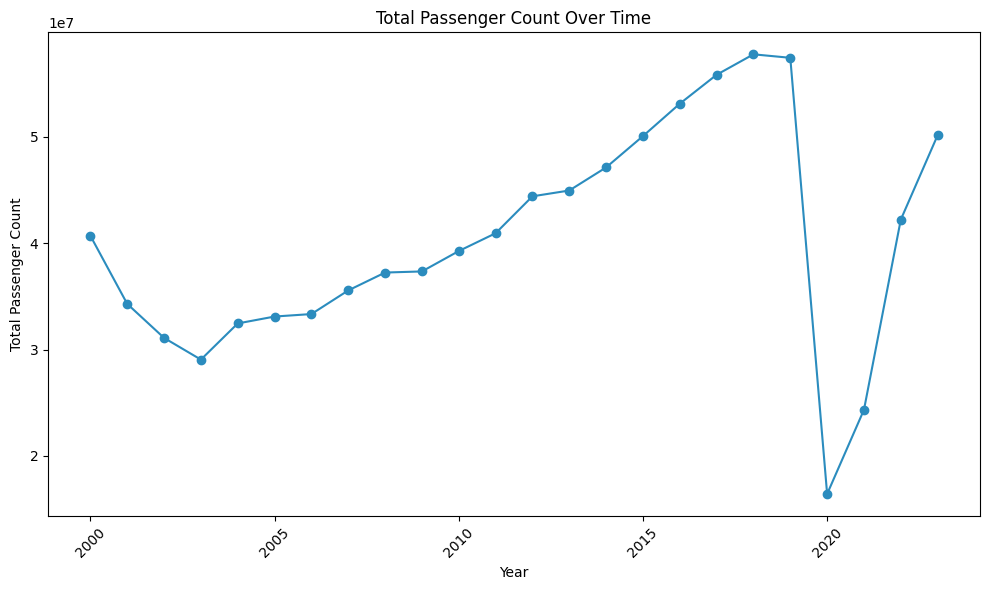

In [82]:
# Group by year and sum 'Passenger Count'
yearly_passenger_count = df.groupby(df['Activity Period Start Date'].dt.year)['Passenger Count'].sum().reset_index()

# Plot the summed 'Passenger Count' for each year
plt.figure(figsize=(10, 6))
plt.plot(yearly_passenger_count['Activity Period Start Date'], yearly_passenger_count['Passenger Count'], marker='o', color='#2b8cbe')
plt.title('Total Passenger Count Over Time')
plt.xlabel('Year')
plt.ylabel('Total Passenger Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Save the plot as a PNG file
plt.savefig('../posts/images/total_passenger_count.png')
plt.tight_layout()
plt.show()

In [ ]:
plt.title('Total Passenger Count Over Time')
plt.xlabel('Year')
plt.ylabel('Total Passenger Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Save the plot as a PNG file
plt.savefig('../posts/images/total_passenger_count.png')

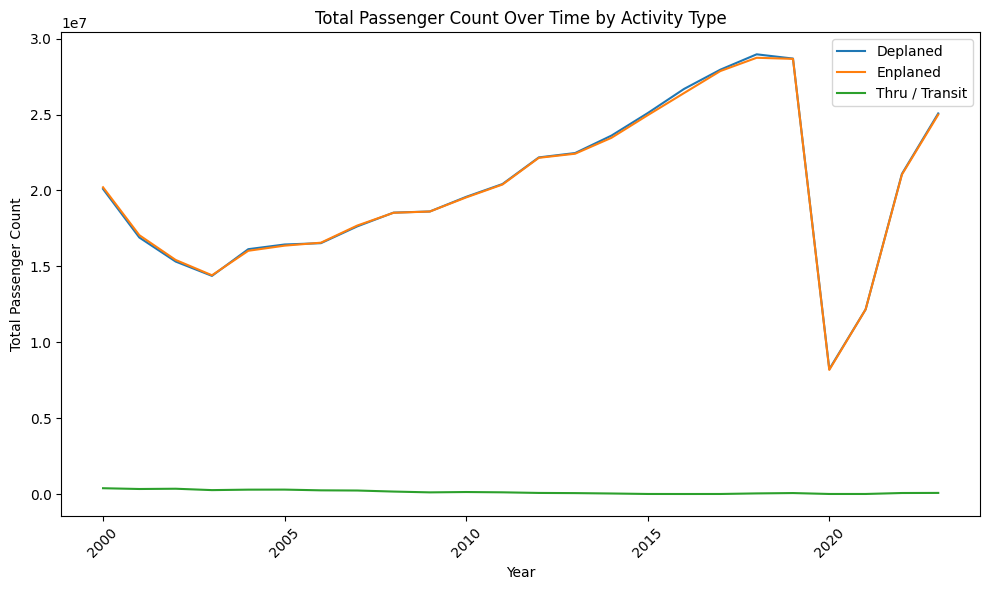

In [34]:
# Group by year and 'Activity Type Code', then sum 'Passenger Count'
grouped_data = df.groupby([df['Activity Period Start Date'].dt.year, 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Plot the summed 'Passenger Count' for each year and activity type
plt.figure(figsize=(10, 6))
for activity_type in grouped_data['Activity Type Code'].unique():
    activity_data = grouped_data[grouped_data['Activity Type Code'] == activity_type]
    plt.plot(activity_data['Activity Period Start Date'], activity_data['Passenger Count'], label=f'{activity_type}')

plt.title('Total Passenger Count Over Time by Activity Type')
plt.xlabel('Year')
plt.ylabel('Total Passenger Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# Group by year and 'Activity Type Code', then sum 'Passenger Count'
grouped_data = df.groupby([df['Activity Period Start Date'].dt.year, 'Activity Type Code'])['Passenger Count'].sum().reset_index()
grouped_data.head()

,Activity Period Start Date,Activity Type Code,Passenger Count
0,2000,Deplaned,20095854
1,2000,Enplaned,20208025
2,2000,Thru / Transit,387562
3,2001,Deplaned,16898855
4,2001,Enplaned,17051699


In [96]:
# Isolate the data for the Rockets and Warriors
deplaned_data = grouped_data[grouped_data['Activity Type Code'] == 'Deplaned'].drop(columns=['Activity Type Code'])
enplaned_data = grouped_data[grouped_data['Activity Type Code'] == 'Enplaned'].drop(columns=['Activity Type Code'])
transit_data = grouped_data[grouped_data['Activity Type Code'] == 'Thru / Transit'].drop(columns=['Activity Type Code'])

deplaned_cds = ColumnDataSource(deplaned_data)
enplaned_cds = ColumnDataSource(enplaned_data)
transit_cds = ColumnDataSource(transit_data)

# Pivot the DataFrame
passenger_data = grouped_data.pivot(index='Activity Period Start Date', columns='Activity Type Code', values='Passenger Count').reset_index()

# Rename the columns
passenger_data.columns.name = None  # Remove the name of the columns index
passenger_data.columns = ['Year', 'Deplaned', 'Enplaned', 'Transit']

passenger_cds = ColumnDataSource(passenger_data)

# Format the tooltip
tooltips = [
            ('Year','@Year'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@Transit'),
           ]

# Create and configure the figure
fig = figure(
    title='Passengers from San Francisco International Airport',
    x_axis_label='Year', y_axis_label='Passenger Count',
    toolbar_location='below', width=800, height=500)

# Render the race as step lines with correct legend_label parameter
fig.line('Year', 'Deplaned', 
         color='#6e80ec', legend_label='Deplaned', 
         source=passenger_cds, line_width=2)
fig.line('Year', 'Enplaned', 
         color='#f16b62', legend_label='Enplaned', 
         source=passenger_cds, line_width=2)
fig.line('Year', 'Transit',
         color='#78c36b', legend_label='Transit', 
         source=passenger_cds, line_width=2)

# Move the legend to the upper left corner
fig.legend.location = 'top_left'
fig.legend.click_policy="hide"

fig.title.align = 'center'

# Add the HoverTool to the figure
fig.add_tools(HoverTool(tooltips=tooltips))

# Specify the name of the HTML file to save
output_file("../posts/images/passengers_type_yearly.html")

# Show the plot
show(fig)

In [94]:
# Monthly trend
# Extract month from the date
df['Month'] = df['Activity Period Start Date'].dt.month

# Group by month and sum the passenger count
monthly_passenger_count = df.groupby('Month')['Passenger Count'].mean().reset_index()

# Create a ColumnDataSource
source = ColumnDataSource(monthly_passenger_count)

# Create the figure
p = figure(x_range=(1, 12), title="Monthly Passenger Trends",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="", width=800, height=500)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Format the tooltip
tooltips = [
    ('Month', '@Month'),
    ("Passenger Count", "@{Passenger Count}{0.00}")
]

# Add a line renderer
p.line(x='Month', y='Passenger Count', line_width=2, source=source, color='#2b8cbe')

# Customize the plot
p.circle(x='Month', y='Passenger Count', size=8, source=source, color='#2b8cbe')

# Set the x-axis ticks to display month names
p.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
p.xaxis.major_label_overrides = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

p.title.align = 'center'

# Add the HoverTool to the figure
p.add_tools(HoverTool(tooltips=tooltips))

# Specify the name of the HTML file to save
output_file("../posts/images/total_passengers_monthly.html")

# Show the plot
show(p)


In [38]:
# Alessia is improving it

# Filter data for the years 2003 and 2020
df_filtered = df[(df['Activity Period Start Date'].dt.year.isin([2003, 2018, 2020, 2023]))]

# Group the data by month and year and sum the passenger counts
df_grouped = df_filtered.groupby([df_filtered['Activity Period Start Date'].dt.month, df_filtered['Activity Period Start Date'].dt.year])['Passenger Count'].sum().unstack()

# Reindex to ensure all months are present even if there's no data for them
df_grouped = df_grouped.reindex(range(1, 13), fill_value=0)

# Rename columns to match the desired format
df_grouped.columns = ['Passenger Count (2003)', 'Passenger Count (2018)', 'Passenger Count (2020)', 'Passenger Count (2023)']

# Rename the index to 'Months'
df_grouped.index.name = 'Months'

source = ColumnDataSource(df_grouped)

p = figure(title="Passenger Counts Across Months", x_axis_label="Months", y_axis_label="Passenger Count",
           x_range=(1, 12))

colors = ['#FF5733', '#006400', '#8B0000', '#008000']

p.line(x='Months', y='Passenger Count (2003)', source=source, legend_label='Passenger Count (2003)', line_width=2, line_color=colors[0])
p.line(x='Months', y='Passenger Count (2018)', source=source, legend_label='Passenger Count (2018)', line_width=2, line_color=colors[1])
p.line(x='Months', y='Passenger Count (2020)', source=source, legend_label='Passenger Count (2020)', line_width=2, line_color=colors[2])
p.line(x='Months', y='Passenger Count (2023)', source=source, legend_label='Passenger Count (2023)', line_width=2, line_color=colors[3])
p.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
p.xaxis.major_label_overrides = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

p.legend.location = "top_left"
p.legend.click_policy="hide"

# Add CustomJS callback to update visibility of lines based on checkbox selection
checkbox_callback = CustomJS(code="""
    var selected_indices = cb_obj.active;
    for (var i = 0; i < cb_obj.labels.length; i++) {
        var line = plot_instance.renderers[i];
        if (selected_indices.includes(i)) {
            line.visible = true;
        } else {
            line.visible = false;
        }
    }
""", args={'plot_instance': p})

show(p)

In [102]:
# Group by month and activity type and sum the passenger count
monthly_activity_count = df.groupby(['Month', 'Activity Type Code'])['Passenger Count'].mean().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df = monthly_activity_count.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

# Create a ColumnDataSource
source = ColumnDataSource(pivot_df)

# Create the figure
p = figure(x_range=month_names, title="Passenger Breakdown by Activity Type",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="", width=730, height=540)

# Define colors for each activity type
fill_colors = ["#6e80ec", "#f16b62", "#78c36b"]
border_colors = ["#000000", "#000000", "#000000"]  # Black borders

# Convert column names to strings
activity_types = pivot_df.columns.astype(str).tolist()

# Create stacked bars with borders
p.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source, legend_label=activity_types, width=0.8)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p.add_tools(HoverTool(tooltips=tooltips))

p.title.align = 'center'

# Set the legend
p.legend.orientation = "horizontal"
p.legend.location = "top_left"
p.legend.label_text_font_size = "8pt"

# Specify the name of the HTML file to save
output_file("../posts/images/passengers_type_monthly.html")

# Show the plot
show(p)

In [40]:
# Same as before but specifically in covid year
# Filter data for the year 2020
df_2020 = df[df['Activity Period Start Date'].dt.year == 2020]

# Group by month and activity type and sum the passenger count
monthly_activity_count = df_2020.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df = monthly_activity_count.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

# Create a ColumnDataSource
source = ColumnDataSource(pivot_df)

# Create the figure
p = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2020)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="", width=700)

# Define colors for each activity type
fill_colors = ["#6e80ec", "#f16b62", "#78c36b"]
border_colors = ["#000000", "#000000", "#000000"]  # Black borders

# Convert column names to strings
activity_types = pivot_df.columns.astype(str).tolist()

# Create stacked bars with borders
p.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source, legend_label=activity_types, width=0.8)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p.add_tools(HoverTool(tooltips=tooltips))

# Set the legend
p.legend.orientation = "horizontal"
p.legend.location = "top_right"
p.legend.label_text_font_size = "8pt"

# Specify the name of the HTML file to save
output_file("../posts/images/2020_passengers_type_monthly.html")

# Show the plot
show(p)

In [41]:
# Same as before but specifically in covid year
# Filter data for the year 2020
df_2020 = df[df['Activity Period Start Date'].dt.year == 2021]

# Group by month and activity type and sum the passenger count
monthly_activity_count = df_2020.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df = monthly_activity_count.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a ColumnDataSource
source = ColumnDataSource(pivot_df)

# Create the figure
p = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2021)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Define colors for each activity type
fill_colors = ["#c9d9d3", "#718dbf", "#e84d60"]
border_colors = ["#000000", "#000000", "#000000"]  # Black borders

# Convert column names to strings
activity_types = pivot_df.columns.astype(str).tolist()

# Create stacked bars with borders
p.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source, legend_label=activity_types)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p.add_tools(HoverTool(tooltips=tooltips))

# Set the legend
p.legend.orientation = "horizontal"
p.legend.location = "top_right"
p.legend.label_text_font_size = "8pt"

# Show the plot
show(p)

In [42]:
# Same as before but specifically in covid year
# Filter data for the year 2020
df_2020 = df[df['Activity Period Start Date'].dt.year == 2019]

# Group by month and activity type and sum the passenger count
monthly_activity_count = df_2020.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df = monthly_activity_count.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a ColumnDataSource
source = ColumnDataSource(pivot_df)

# Create the figure
p = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2019)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Define colors for each activity type
fill_colors = ["#c9d9d3", "#718dbf", "#e84d60"]
border_colors = ["#000000", "#000000", "#000000"]  # Black borders

# Convert column names to strings
activity_types = pivot_df.columns.astype(str).tolist()

# Create stacked bars with borders
p.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source, legend_label=activity_types)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p.add_tools(HoverTool(tooltips=tooltips))

# Set the legend
p.legend.orientation = "horizontal"
p.legend.location = "top_right"
p.legend.label_text_font_size = "8pt"

# Show the plot
show(p)

In [129]:
from bokeh.models.layouts import Row
from bokeh.plotting import show
from bokeh.models.layouts import Row
# Filter data for the year 2019
df_2019 = df[df['Activity Period Start Date'].dt.year == 2019]

# Group by month and activity type and sum the passenger count
monthly_activity_count_2019 = df_2019.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df_2019 = monthly_activity_count_2019.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Filter data for the year 2020
df_2020 = df[df['Activity Period Start Date'].dt.year == 2020]

# Group by month and activity type and sum the passenger count
monthly_activity_count_2020 = df_2020.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df_2020 = monthly_activity_count_2020.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Filter data for the year 2021
df_2021 = df[df['Activity Period Start Date'].dt.year == 2021]

# Group by month and activity type and sum the passenger count
monthly_activity_count_2021 = df_2021.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df_2021 = monthly_activity_count_2021.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

# Create a ColumnDataSource
source_2019 = ColumnDataSource(pivot_df_2019)
source_2020 = ColumnDataSource(pivot_df_2020)
source_2021 = ColumnDataSource(pivot_df_2021)

from bokeh.models import Range1d

y_range = Range1d(start=0, end=6e6) 

# Create the figure for 2019
p_2019 = figure(x_range=month_names, y_range=y_range, title="Passenger distribution in 2019",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")
p_2019.title.align = 'center'

# Create stacked bars with borders for 2019
p_2019.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source_2019, legend_label=activity_types, width=0.8)

# Create the figure for 2020
p_2020 = figure(x_range=month_names, y_range=y_range, title="Passenger distribution in 2020",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

p_2020.title.align = 'center'

# Create stacked bars with borders for 2020
p_2020.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source_2020, legend_label=activity_types, width=0.8)

# Create the figure for 2021
p_2021 = figure(x_range=month_names, y_range=y_range, title="Passenger distribution in 2021",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")
p_2021.title.align = 'center'

# Create stacked bars with borders for 2021
p_2021.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source_2021, legend_label=activity_types, width=0.8)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p_2019.add_tools(HoverTool(tooltips=tooltips))
p_2020.add_tools(HoverTool(tooltips=tooltips))
p_2021.add_tools(HoverTool(tooltips=tooltips))

p_2019.xaxis.major_label_orientation = 0.5
p_2020.xaxis.major_label_orientation = 0.5
p_2021.xaxis.major_label_orientation = 0.5

# Remove legend for 2020 and 2021
p_2019.legend.visible = False
p_2021.legend.visible = False

# Set the legend for 2020
p_2020.legend.orientation = "horizontal"
p_2020.legend.location = "top_right"
p_2020.legend.label_text_font_size = "8pt"

# grid = gridplot([[p_2019, p_2020, p_2021]], sizing_mode='scale_width')
# Create the grid layout
grid = Row(children=[p_2019, p_2020, p_2021], sizing_mode='scale_width')

# Add a title to the grid
grid.name = "Grid Title"

# Show the grid
show(grid)

# Specify the name of the HTML file to save
output_file("../posts/images/2019-2021_passengers_type_monthly.html")

# Show the plot
show(grid)


In [119]:
from bokeh.models import Legend

# Combine data for 2019, 2020, and 2021
combined_df = pd.concat([pivot_df_2019, pivot_df_2020, pivot_df_2021], keys=['2019', '2020', '2021'])

# Create a ColumnDataSource for combined data
source_combined = ColumnDataSource(combined_df)

# Create the figure for combined data
p_combined = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2019-2021)",
                    x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None, tools="")

# Create stacked bars with borders for combined data
p_combined.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
                      source=source_combined, legend_label=activity_types, width=0.8)

# Format the tooltip
tooltips = [
    ('Month', '@Month'),
    ('Deplaned count', '@Deplaned'),
    ('Enplaned count', '@Enplaned'),
    ('Transit count', '@{Thru / Transit}'),
]

p_combined.add_tools(HoverTool(tooltips=tooltips))

# Rotate x-axis labels
p_combined.xaxis.major_label_orientation = 0.5  # Rotate by 45 degrees

# Remove the individual legends for 2019, 2020, and 2021
p_2019.legend.visible = False
p_2020.legend.visible = False
p_2021.legend.visible = False

# Create a combined legend
legend = Legend(items=[
    ("Deplaned", [p_combined.renderers[0]]),
    ("Enplaned", [p_combined.renderers[1]]),
    ("Transit", [p_combined.renderers[2]])
])

# Add the legend below the grid layout
p_combined.add_layout(legend, 'below')

# Specify the name of the HTML file to save
output_file("../posts/images/2019-2021_passengers_type_monthly.html")

# Show the plot
show(p_combined)


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='Month' [no close matches] {renderer: GlyphRenderer(id='p9659', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='Month' [no close matches] {renderer: GlyphRenderer(id='p9638', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='Month' [no close matches] {renderer: GlyphRenderer(id='p9649', ...)}


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='Month' [no close matches] {renderer: GlyphRenderer(id='p9659', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='Month' [no close matches] {renderer: GlyphRenderer(id='p9638', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='Month' [no close matches] {renderer: GlyphRenderer(id='p9649', ...)}


In [78]:
# Filter data for the year 2002
df_2002 = df[df['Activity Period Start Date'].dt.year == 2002]

# Group by month and activity type and sum the passenger count
monthly_activity_count_2002 = df_2002.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df_2002 = monthly_activity_count_2002.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Filter data for the year 2003
df_2003 = df[df['Activity Period Start Date'].dt.year == 2003]

# Group by month and activity type and sum the passenger count
monthly_activity_count_2003 = df_2003.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df_2003 = monthly_activity_count_2003.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Filter data for the year 2004
df_2004 = df[df['Activity Period Start Date'].dt.year == 2004]

# Group by month and activity type and sum the passenger count
monthly_activity_count_2004 = df_2004.groupby(['Month', 'Activity Type Code'])['Passenger Count'].sum().reset_index()

# Pivot the DataFrame to get a suitable format for the stacked bar chart
pivot_df_2004 = monthly_activity_count_2004.pivot(index='Month', columns='Activity Type Code', values='Passenger Count').fillna(0)

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

# Create a ColumnDataSource
source_2002 = ColumnDataSource(pivot_df_2002)
source_2003 = ColumnDataSource(pivot_df_2003)
source_2004 = ColumnDataSource(pivot_df_2004)

# Create the figure for 2002
p_2002 = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2002)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Create stacked bars with borders for 2002
p_2002.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source_2002, legend_label=activity_types, width=0.8)

# Create the figure for 2003
p_2003 = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2003)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Create stacked bars with borders for 2003
p_2003.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source_2003, legend_label=activity_types, width=0.8)

# Create the figure for 2004
p_2004 = figure(x_range=month_names, title="Passenger Breakdown by Activity Type (2004)",
           x_axis_label='Month', y_axis_label='Passenger Count', toolbar_location=None,
           tools="")

# Create stacked bars with borders for 2004
p_2004.vbar_stack(stackers=activity_types, x='Month', color=fill_colors, line_color=border_colors, line_width=0.5,
             source=source_2004, legend_label=activity_types, width=0.8)

# Format the tooltip
tooltips = [
            ('Month','@Month'),
            ('Deplaned count', '@Deplaned'),
            ('Enplaned count', '@Enplaned'),
            ('Transit count','@{Thru / Transit}'),
           ]

p_2002.add_tools(HoverTool(tooltips=tooltips))
p_2003.add_tools(HoverTool(tooltips=tooltips))
p_2004.add_tools(HoverTool(tooltips=tooltips))

# Remove legend for 2003 and 2004
p_2002.legend.visible = False
p_2004.legend.visible = False

# Set the legend for 2003
p_2003.legend.orientation = "vertical"
p_2003.legend.location = "top_left"
p_2003.legend.label_text_font_size = "6pt"

# Create a grid plot
grid = gridplot([[p_2002, p_2003, p_2004]], sizing_mode='scale_width')

# Specify the name of the HTML file to save
output_file("../posts/images/2002-2004_passengers_type_monthly.html")

# Show the plot
show(grid)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

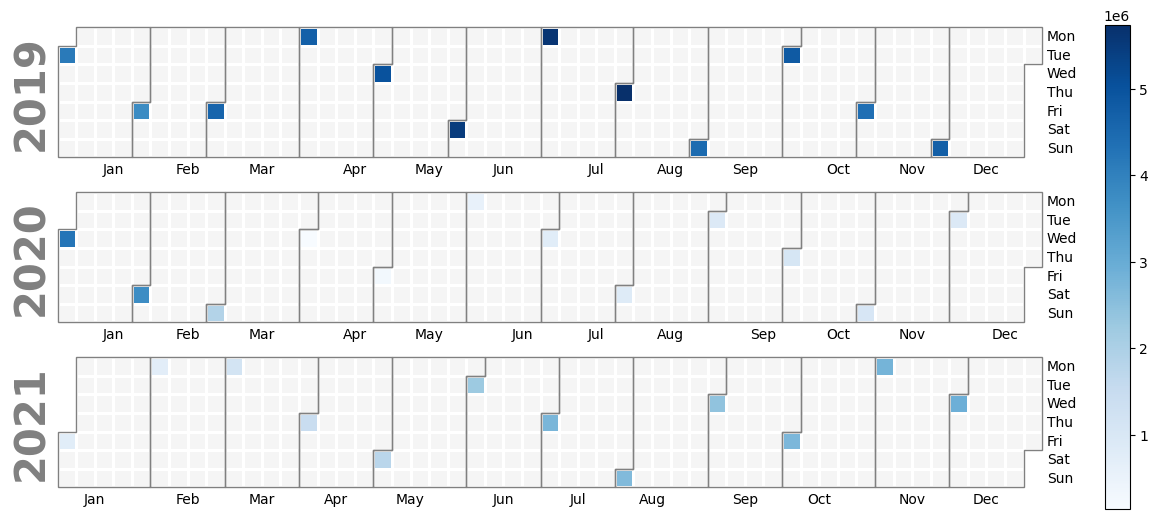

In [109]:
# CALENDAR WITH CALPLOT TO SHOW THE PROBLEM IN THE DATASET
import pandas as pd
import calplot

# Convert 'Activity Period Start Date' column to datetime
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])

# Filter data for the years 2019 to 2021
df_filtered = df[df['Activity Period Start Date'].dt.year.isin([2019, 2020, 2021])]

# Group by 'Activity Period Start Date' and sum the 'Passenger Count'
grouped_data = df_filtered.groupby('Activity Period Start Date')['Passenger Count'].sum()

# Create a calendar plot
calplot.calplot(grouped_data, yearlabels=True, cmap='Blues')

# Save the plot as a PNG file
plt.savefig('../posts/images/error_calendar.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()